In [1]:
# Run this if you don't have qiskit and mitiq installed

!pip install qiskit --quiet
!pip install mitiq --quiet

import warnings
warnings.filterwarnings(action='ignore') # Optional warning filter

#Introduction to Zero Noise Extrapolation using Mitiq and Qiskit

## By Sahil Gulania - Argonne National Laboratory

Zero Noise Extrapolation (ZNE) is a technique used in quantum computation to mitigate the effects of noise and errors that occur during quantum computations. Quantum computers are inherently susceptible to various sources of noise and errors, such as environmental interference, imperfect gates, and decoherence. These factors can lead to inaccurate results and limit the computational power of quantum systems.

ZNE aims to reduce the impact of noise by amplifying the signal associated with the desired quantum computation while attenuating the effects of noise. The basic idea behind ZNE is to perform multiple measurements or computations with different noise levels and use a combination of these results to extract the noise-free outcome. This is achieved by leveraging the statistical properties of the noise and the signal of interest.

The ZNE technique involves the following steps:

1. Preparation: Initially, the quantum system is prepared in a specific state or input suitable for the desired computation.

2. Noise amplification: To amplify the signal and suppress noise, multiple runs of the computation are performed with different noise levels. This can be achieved by introducing controlled noise sources or intentionally varying system parameters.

3. Measurement: The computation is repeated for each noise level, and the corresponding measurements or outcomes are recorded.

4. Extrapolation: The collected measurements are then analyzed using extrapolation techniques to estimate the noise-free result. The extrapolation process takes advantage of the statistical properties of noise to separate the signal from the noise.

5. Error correction: Finally, error correction techniques can be applied based on the extrapolated noise-free results to further improve the accuracy of the computation.

By combining the results obtained from different noise levels, ZNE allows for the extraction of a more accurate outcome compared to a single noisy computation. It effectively suppresses the influence of noise on the final result, enabling more reliable quantum computations.

Zero Noise Extrapolation is a promising approach for overcoming the limitations posed by noise in quantum computation, contributing to the development of more robust and reliable quantum algorithms and applications.



$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$


# Step 1 - Preperation of state using Qiskit

We are going to use 4 qubits system to estimate the probability of $\ket{0000}$ after the execution of a quantum circuit. The initial state will be $\ket{\Psi} = \ket{0000}$ and after the action of gates the final state is also $\ket{0000}$. This procedure allows us to compare the accuracy of ZNE technique.

In [2]:
import qiskit
import numpy as np

from mitiq.interface import convert_to_mitiq, convert_from_mitiq

n_qubits = 4

qubits = qiskit.QuantumRegister(4)
circuit = qiskit.QuantumCircuit(qubits)

circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)
circuit.cnot(0, 1)
circuit.cnot(2, 3)
circuit.cnot(1, 2)
circuit.cnot(1, 2)
circuit.cnot(0, 1)
circuit.cnot(2, 3)
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)

print(f"Circuit used for ZNE with {len(circuit)} gates generated.")
print(circuit)

Circuit used for ZNE with 14 gates generated.
      ┌───┐                    ┌───┐
q0_0: ┤ H ├──■──────────────■──┤ H ├
      ├───┤┌─┴─┐          ┌─┴─┐├───┤
q0_1: ┤ H ├┤ X ├──■────■──┤ X ├┤ H ├
      ├───┤└───┘┌─┴─┐┌─┴─┐└───┘├───┤
q0_2: ┤ H ├──■──┤ X ├┤ X ├──■──┤ H ├
      ├───┤┌─┴─┐└───┘└───┘┌─┴─┐├───┤
q0_3: ┤ H ├┤ X ├──────────┤ X ├┤ H ├
      └───┘└───┘          └───┘└───┘


# Step 2 - Check the expectation value with a noiseless simulator.

By doing this step we reconform the expectation value of the final state.

In [3]:
# Set the number of shots
shots = 10 ** 5

# Initialize ideal backend (classical noiseless simulator)
ideal_backend = qiskit.Aer.get_backend('aer_simulator')

# Append measurements
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# Run and get count
job = ideal_backend.run(circuit_to_run, shots=shots)
counts = job.result().get_counts()

# Expectation value of O =|0000><0000|
ideal_value = counts["0000"] / shots
ideal_value


1.0

# Step 3 - Load a noisy simulator from QisKit

We are going to use a noisy simulator provided by IBM which mimicks one of their real device. This allows us to capture the physics and feasibility of ZNE without waiting in queue for running jobs on real device (https://qiskit.org/documentation/apidoc/providers_fake_provider.html).

It also allow us to compute the effects of noise on the quantum circuit. The expectation value is different from the ideal expectation

In [4]:
from qiskit.test.mock import FakeManilaV2

# Set the number of shots
shots = 10 ** 5

# Select a noisy backend
noisy_backend = FakeManilaV2() # Simulator with noise model similar to "ibmq_manila"

# Append measurements
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# Run and get counts
print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
job = noisy_backend.run(circuit_to_run, shots=shots)
counts = job.result().get_counts()

# Compute expectation value of the observable O =|0000><0000|
noisy_value = counts["0000"] / shots
noisy_value

Executing circuit with 14 gates using 100000 shots.


0.82737

# Step 4 - Setpu Mitiq variable

This step allows uus to directly utilize the modules developed in Mitiq for ZNE. First we define the noisy parameters using the Qiskit noisy simulator.

In [5]:
def executor(circuit, shots=10 ** 5):
    """Executes the input circuit and returns the noisy expectation value <O>, where O=|0000>0000|.
    """
    # Select a noisy backend
    # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_manila")
    noisy_backend = FakeManilaV2() # Simulator with noise model similar to "ibmq_manila"

    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run.measure_all()

    # Run and get counts
    print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
    job = noisy_backend.run(circuit_to_run, shots=shots)
    counts = job.result().get_counts()

    # Compute expectation value of the observable O =|0000><0000|
    noisy_value = counts["0000"] / shots
    return noisy_value

Now we setup the folding method. We are going to use global folding technique.

In [6]:
from mitiq import zne

# Choise a unitary folding function
noise_scaling_function = zne.scaling.fold_global


#Step 5 - Setup parameters for enhancing the noise.

In [7]:
factory = zne.inference.ExpFactory(scale_factors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
# Examples:

# Richardson extrapolation
# factory = zne.inference.RichardsonFactory(scale_factors = [1, 2, 3])

# Exponential extrapolation
# factory = zne.inference.ExpFactory(scale_factors = [1, 2, 3], asymptote=0.25)

# Exponential adaptive extrapolation
# factory = zne.inference.AdaExpFactory(steps=10, asymptote=0.25)



In [8]:
zne_value = zne.execute_with_zne(circuit, executor, scale_noise=noise_scaling_function, factory=factory)

unmitigated_error = abs(ideal_value - noisy_value)
zne_error = abs(ideal_value - zne_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (ZNE): {zne_error}")


Executing circuit with 14 gates using 100000 shots.
Executing circuit with 28 gates using 100000 shots.
Executing circuit with 42 gates using 100000 shots.
Executing circuit with 56 gates using 100000 shots.
Executing circuit with 70 gates using 100000 shots.
Executing circuit with 84 gates using 100000 shots.
Executing circuit with 98 gates using 100000 shots.
Executing circuit with 112 gates using 100000 shots.
Executing circuit with 126 gates using 100000 shots.
Executing circuit with 140 gates using 100000 shots.
Executing circuit with 154 gates using 100000 shots.
Executing circuit with 168 gates using 100000 shots.
Estimation error without Mitiq   : 0.17262999999999995
Estimation error with Mitiq (ZNE): 0.09860150867569162


In [9]:
print(f"ZNE reduced the estimation error by {(unmitigated_error - zne_error) / unmitigated_error :.1%}.")

ZNE reduced the estimation error by 42.9%.


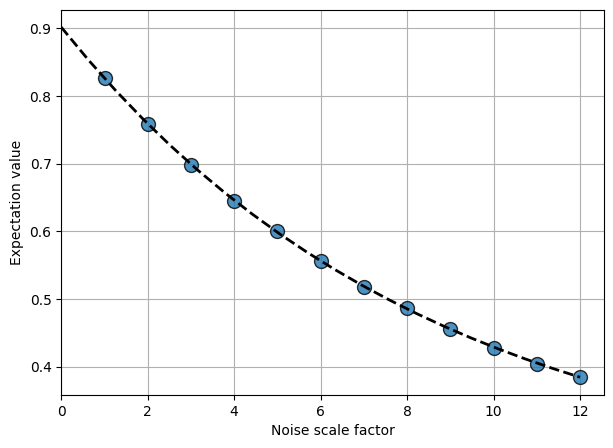

In [10]:
_ = factory.plot_fit()

# Running larger depth quantum circuit

In [11]:
n_qubits = 3

qubits = qiskit.QuantumRegister(3)
circuit = qiskit.QuantumCircuit(qubits)

circuit.x(0)
circuit.x(2)
circuit.rx(np.pi/2, 1)
circuit.rx(np.pi/2, 2)
circuit.cnot(1, 2)
circuit.rx(3.071535977980565, 1)
circuit.rx(3.124076467116959, 2)
circuit.cnot(1, 2)
circuit.rx(-np.pi/2, 1)
circuit.rx(-np.pi/2, 2)
circuit.rx(np.pi/2, 0)
circuit.rx(np.pi/2, 1)
circuit.cnot(0, 1)
circuit.rx(0.07934104435895009, 1)
circuit.rx(0.019833244938295334, 2)
circuit.cnot(0, 1)
circuit.rx(-np.pi/2, 0)
circuit.rx(-np.pi/2, 1)
circuit.rx(np.pi/2, 1)
circuit.rx(np.pi/2, 2)
circuit.cnot(1, 2)
circuit.rx(3.132306671921119, 1)
circuit.rx(3.1392691406020656, 2)
circuit.cnot(1, 2)
circuit.rx(-np.pi/2, 1)
circuit.rx(-np.pi/2, 2)
print(f"Circuit used for ZNE with {len(circuit)} gates generated.")
print(circuit)

Circuit used for ZNE with 26 gates generated.
         ┌───┐   ┌─────────┐                                    »
q1_0: ───┤ X ├───┤ Rx(π/2) ├────────────────────────────────────»
      ┌──┴───┴──┐└─────────┘     ┌────────────┐     ┌──────────┐»
q1_1: ┤ Rx(π/2) ├─────────────■──┤ Rx(3.0715) ├──■──┤ Rx(-π/2) ├»
      └──┬───┬──┘┌─────────┐┌─┴─┐├────────────┤┌─┴─┐├──────────┤»
q1_2: ───┤ X ├───┤ Rx(π/2) ├┤ X ├┤ Rx(3.1241) ├┤ X ├┤ Rx(-π/2) ├»
         └───┘   └─────────┘└───┘└────────────┘└───┘└──────────┘»
«                                                      ┌──────────┐           »
«q1_0: ─────────────────────■───────────────────────■──┤ Rx(-π/2) ├───────────»
«        ┌─────────┐      ┌─┴─┐   ┌──────────────┐┌─┴─┐├──────────┤┌─────────┐»
«q1_1: ──┤ Rx(π/2) ├──────┤ X ├───┤ Rx(0.079341) ├┤ X ├┤ Rx(-π/2) ├┤ Rx(π/2) ├»
«      ┌─┴─────────┴──┐┌──┴───┴──┐└──────────────┘└───┘└──────────┘└─────────┘»
«q1_2: ┤ Rx(0.019833) ├┤ Rx(π/2) ├────────────────────────────────────────────»
«      └────

In [12]:
# Append measurements
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# Run and get count
job = ideal_backend.run(circuit_to_run, shots=shots)
counts = job.result().get_counts()

# Expectation value of R=|101><101|
ideal_value = counts["101"] / shots
ideal_value

0.99671

In [13]:
# Append measurements
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# Run and get counts
print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
job = noisy_backend.run(circuit_to_run, shots=shots)
counts = job.result().get_counts()

# Compute expectation value of the observable R=|101><101|
noisy_value = counts["101"] / shots
noisy_value

Executing circuit with 26 gates using 100000 shots.


0.64121

In [14]:
def executor_new(circuit, shots=10 ** 5):
    """Executes the input circuit and returns the noisy expectation value <R>, where R=|101>101|.
    """
    # Select a noisy backend
    # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_manila")
    noisy_backend = FakeManilaV2() # Simulator with noise model similar to "ibmq_manila"

    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run.measure_all()

    # Run and get counts
    print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
    job = noisy_backend.run(circuit_to_run, shots=shots)
    counts = job.result().get_counts()

    # Compute expectation value of the observable R=|101><101|
    noisy_value = counts["101"] / shots
    return noisy_value

In [15]:
zne_value = zne.execute_with_zne(circuit, executor_new, scale_noise=noise_scaling_function, factory=factory)

unmitigated_error = abs(ideal_value - noisy_value)
zne_error = abs(ideal_value - zne_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (ZNE): {zne_error}")

Executing circuit with 26 gates using 100000 shots.
Executing circuit with 52 gates using 100000 shots.
Executing circuit with 78 gates using 100000 shots.
Executing circuit with 104 gates using 100000 shots.
Executing circuit with 130 gates using 100000 shots.
Executing circuit with 156 gates using 100000 shots.
Executing circuit with 182 gates using 100000 shots.
Executing circuit with 208 gates using 100000 shots.
Executing circuit with 234 gates using 100000 shots.
Executing circuit with 260 gates using 100000 shots.
Executing circuit with 286 gates using 100000 shots.
Executing circuit with 312 gates using 100000 shots.
Estimation error without Mitiq   : 0.35550000000000004
Estimation error with Mitiq (ZNE): 0.29043677863561534


In [16]:
print(f"ZNE reduced the estimation error by {(unmitigated_error - zne_error) / unmitigated_error :.1%}.")

ZNE reduced the estimation error by 18.3%.


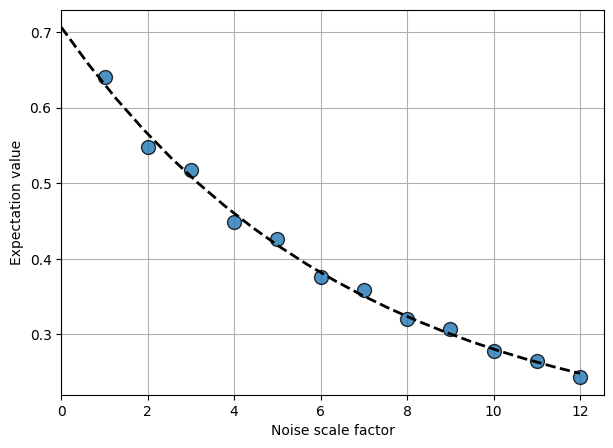

In [17]:
_ = factory.plot_fit()

In [18]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.24.1', 'qiskit-aer': '0.12.1', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.43.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}